# Portfolio Optimization for selected assets

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco

[*********************100%***********************]  11 of 11 completed


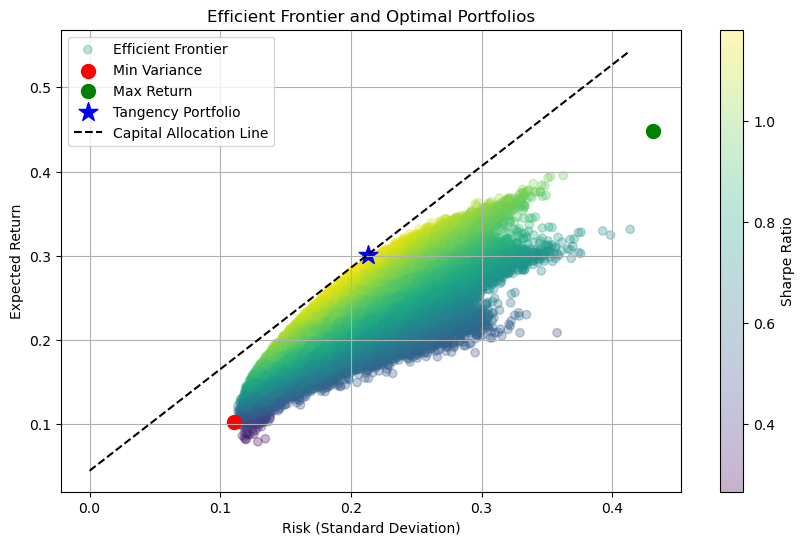

In [30]:
assets = ['AMZN', 'AAPL', 'MCD', 'COST', 'LLY', 'NVDA', 'NFLX', 'MSFT', 'JPM', 'META', 'GC=F'] 

# Define time period (last 20 years)
start_date = '2004-01-30'
end_date = '2024-01-30'

data = yf.download(assets, start=start_date, end=end_date)['Adj Close']

returns = np.log(data / data.shift(1)).dropna()

annual_returns = returns.mean() * 252
annual_cov_matrix = returns.cov() * 252

# Risk-free rate
rf = 0.045

def portfolio_performance(weights, mean_returns, cov_matrix):
    port_return = np.dot(weights, mean_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (port_return - rf) / port_volatility
    return port_return, port_volatility, sharpe_ratio

def min_variance_portfolio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = sco.minimize(lambda x: portfolio_performance(x, *args)[1], num_assets * [1./num_assets],
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def max_return_portfolio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = sco.minimize(lambda x: -portfolio_performance(x, *args)[0], num_assets * [1./num_assets],
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def tangency_portfolio(mean_returns, cov_matrix, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = sco.minimize(lambda x: -portfolio_performance(x, *args)[2], num_assets * [1./num_assets],
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

min_var_result = min_variance_portfolio(annual_returns, annual_cov_matrix)
max_ret_result = max_return_portfolio(annual_returns, annual_cov_matrix)
tangency_result = tangency_portfolio(annual_returns, annual_cov_matrix, rf)

def extract_results(result):
    weights = np.round(result.x, 4)
    ret, risk, sharpe = portfolio_performance(weights, annual_returns, annual_cov_matrix)
    return [ret, risk, sharpe] + list(weights)

columns = ['Return', 'Risk', 'Sharpe Ratio'] + assets
results_df = pd.DataFrame(
    [extract_results(min_var_result),
     extract_results(max_ret_result),
     extract_results(tangency_result)],
    index=["Min Variance", "Max Return", "Tangency"],
    columns=columns
)


# Monte Carlo simulation for efficient frontier
num_portfolios = 1000000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(len(assets)), size=1).flatten()
    weights_record.append(weights)
    ret, risk, sharpe = portfolio_performance(weights, annual_returns, annual_cov_matrix)
    results[0, i] = ret
    results[1, i] = risk
    results[2, i] = sharpe

# Efficiency Frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[1], results[0], c=results[2], cmap='viridis', alpha=0.3, label="Efficient Frontier")
plt.colorbar(label='Sharpe Ratio')
plt.scatter(results_df['Risk']["Min Variance"], results_df['Return']["Min Variance"], c='red', marker='o', s=100, label="Min Variance")
plt.scatter(results_df['Risk']["Max Return"], results_df['Return']["Max Return"], c='green', marker='o', s=100, label="Max Return")
plt.scatter(results_df['Risk']["Tangency"], results_df['Return']["Tangency"], c='blue', marker='*', s=200, label="Tangency Portfolio")

# Capital Allocation Line (CAL)
x = np.linspace(0, max(results[1]), 100)
y = rf + (results_df['Return']["Tangency"] - rf) / results_df['Risk']["Tangency"] * x
plt.plot(x, y, linestyle='dashed', color='black', label='Capital Allocation Line')

plt.xlabel("Risk (Standard Deviation)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier and Optimal Portfolios")
plt.legend()
plt.grid()
plt.show()